# Simple classification with pytorch

## Data processing

### Create a csv file 

In [18]:
import os 
os.chdir('/home/aurelien/Desktop/pytorch-sea-animals/')
import yaml
from src.data.filter_classes import make_csv_path

# Read params
params = yaml.safe_load(open('params.yaml'))
excluded_classes = params['prepare']['excluded_classes']

make_csv_path(excluded_labels=excluded_classes)

(11696, 2)
Csv file constituted with 9927 images, representing 16 classes, excluding Crabs, Corals, Dolphin


### Get the mean and std for image standardization

In [21]:
# Modules
import torch
from src.data.CustomImageDataset import CustomImageDataset
import torchvision.transforms as T

image_size = params['general']['image_size']

transformf = T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor()
])

dataset = CustomImageDataset(annotations_file='./data/interim/filepath.csv', transform=transformf)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
def get_mean_and_std(loader):
    mean = 0. 
    std = 0. 
    total_images_count = 0

    for images,_ in loader:
        image_count_batch = images.size(0)
        images = images.view(image_count_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_batch
    
    mean /= total_images_count
    std /= total_images_count
    return mean, std
mean, std = get_mean_and_std(dataloader)

dict_mean_std = {'mean': mean.tolist(),
'std': std.tolist()}

print(dict_mean_std)

with open("./data/processed/image_mean_std.yaml", "w") as outfile:
    yaml.dump(dict_mean_std, outfile)

227
{'mean': [0.3129682242870331, 0.39756929874420166, 0.41254743933677673], 'std': [0.18169072270393372, 0.18498729169368744, 0.1831035315990448]}


### Plot some images for verification

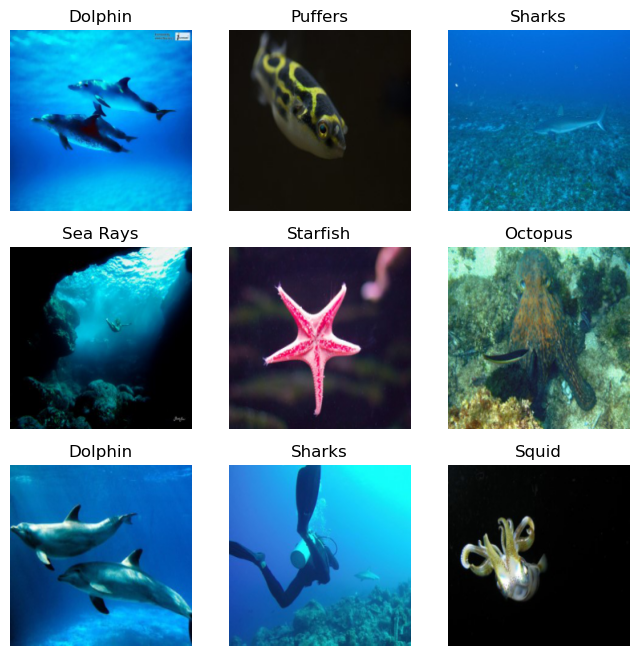

In [4]:
# Modules
import torch
import matplotlib.pyplot as plt 

# Scripts
label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset.__len__(), size=(1,)).item()
    img, y = dataset.__getitem__(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

### Split the dataset + data augmentation
 

In [5]:
# Modules
import torch
from sklearn.model_selection import train_test_split

# Script

def split_dataset(annotations_file, output_folder, test_split=0.2, val_split=0.2, random_seed=99):
    dataset = pd.read_csv(annotations_file)
    train, test = train_test_split(dataset, stratify=dataset['label'], test_size=test_split, random_state=random_seed)
    train, val = train_test_split(train, stratify=train['label'], test_size=val_split, random_state=random_seed)
    train.to_csv(os.path.join(output_folder, 'train.csv'), index=False)
    train.to_csv(os.path.join(output_folder, 'val.csv'), index=False)
    test.to_csv(os.path.join(output_folder, 'test.csv'), index=False)


split_dataset(annotations_file='../data/interim/filepath.csv', output_folder='../data/processed', val_split=0.2, random_seed=99)


Feature batch shape: torch.Size([64, 3, 227, 227])
Labels batch shape: torch.Size([64])


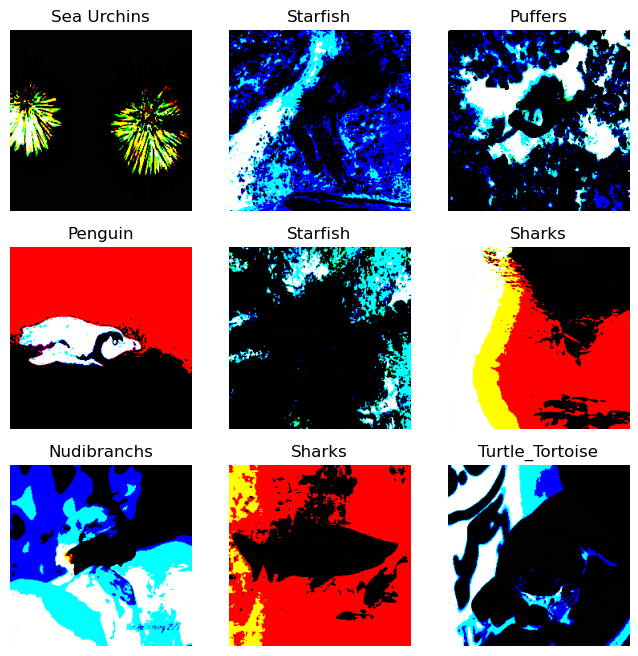

In [6]:
# Modules
import yaml
import pandas as pd
import torchvision.transforms as T
from torch.utils.data import DataLoader

# Dependencies
mean_std = yaml.safe_load(open('../data/processed/image_mean_std.yaml'))

# Parameters
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
image_size = (227,227)

# Scripts 
train_T=T.Compose([
    T.AutoAugment(policies[0]),
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=train_T)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_T=T.Compose([
    T.ToPILImage(),
    T.Resize(size=image_size),
    T.ToTensor(),
    T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
    #T.ConvertImageDtype(torch.float)
    ])

val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=val_T)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=val_T)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

label_map = yaml.safe_load(open('../data/processed/labels_map.yaml'))

denorm = T.Normalize(
    mean=[-m / s for m, s in zip(mean_std['mean'], mean_std['std'])],
    std=[1.0 / s for s in mean_std['std']])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).numpy().astype('uint8'))
plt.show()


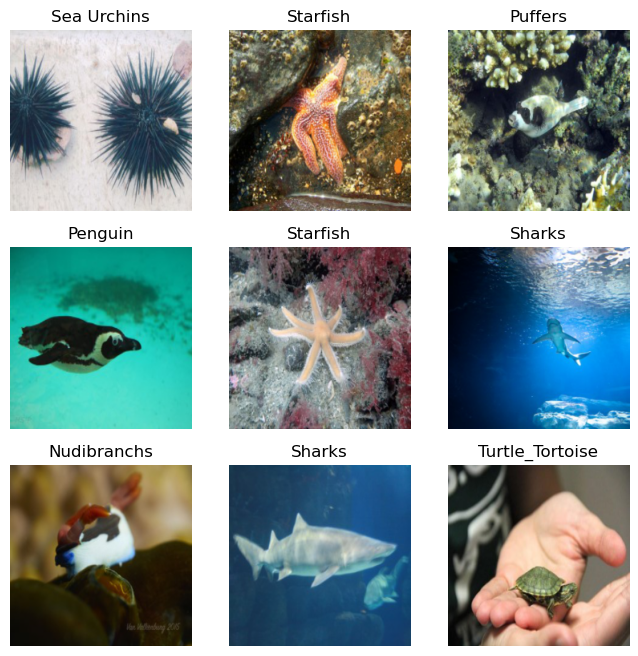

In [7]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    img = train_features[i].squeeze()
    y = train_labels[i]
    figure.add_subplot(rows, cols, i)
    plt.title(label_map[y.item()])
    plt.axis("off")
    plt.imshow(denorm(img).permute(1, 2, 0))
plt.show()

## Training the network

To do: 
- Define early stopping 
- Register parameters early stopping with mlflow


In [9]:
import torchvision
from torch import nn
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.optim import Adam

# Define the LightningModule

class mobilenetv3_fe(pl.LightningModule):

    def __init__(self, n_classes, learning_rate):
        super().__init__()

        # Parameters
        self.lr = learning_rate
        self.num_classes = n_classes

        # Init a pretrained mobilenetv3 model
        
        self.model = torchvision.models.mobilenet_v3_small(weights='IMAGENET1K_V1', pretrained=True, progress=True)
        
        # Feature extraction : freeze the network
        for param in self.model.parameters():
                param.requires_grad = False
        
        # Replacing last layer with new layer (not frozen)
        num_ftrs = self.model.classifier[-1].in_features
        self.model.classifier[3] = nn.Linear(num_ftrs, self.num_classes)


    def forward(self, x):
        out = self.model(x)
        return out
    
    def loss_fn(self, out, target):
        return nn.CrossEntropyLoss()(out.view(-1, self.num_classes), target)
    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)

        logits = nn.Softmax(-1)(out) 
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, label, task='multiclass', num_classes=self.num_classes)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def evaluate(self, batch, stage=None):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        loss = self.loss_fn(out, label)
        logits = nn.Softmax(-1)(out) 
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, label, task='multiclass', num_classes=self.num_classes)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
        
    def validation_step(self,batch,batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")


    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, labels = batch
        label = labels.view(-1)
        img = images.view(-1, 3, images.size(2), images.size(2))
        out = self(img)
        out = nn.Softmax(-1)(out) 
        return torch.argmax(out,dim=1)


class LightDataset(pl.LightningDataModule):
    def __init__(self, batch_size=16):
        super().__init__()
        self.batch_size = batch_size

        self.train_T=T.Compose([
            T.AutoAugment(policies[0]),
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

        self.val_T=T.Compose([
            T.ToPILImage(),
            T.Resize(size=image_size),
            T.ToTensor(),
            T.Normalize(mean=mean_std['mean'], std=mean_std['std']),
            #T.ConvertImageDtype(torch.float)
            ])

    def train_dataloader(self):
        train_dataset = CustomImageDataset(annotations_file='../data/processed/train.csv', transform=self.train_T)
        train_loader = DataLoader(train_dataset,
                            batch_size=self.batch_size,
                            shuffle=True, num_workers=8)
        return train_loader
    
    def val_dataloader(self):
        val_dataset = CustomImageDataset(annotations_file='../data/processed/val.csv', transform=self.val_T)
        valid_loader = DataLoader(val_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return valid_loader
    
    def test_dataloader(self):
        test_dataset = CustomImageDataset(annotations_file='../data/processed/test.csv', transform=self.val_T)
        test_loader = DataLoader(test_dataset,
                            batch_size=self.batch_size,
                            shuffle=False, num_workers=8)       
        return test_loader

In [13]:
import mlflow.pytorch
from mlflow import MlflowClient
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

mlflow.set_tracking_uri("../mlruns")
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in MlflowClient().list_artifacts(r.info.run_id, "model")]
    print("run_id: {}".format(r.info.run_id))
    print("artifacts: {}".format(artifacts))
    print("params: {}".format(r.data.params))
    print("metrics: {}".format(r.data.metrics))
    print("tags: {}".format(tags))

# Callbacks

early_stop_callback = EarlyStopping(monitor="val_acc",
 min_delta=0.00, patience=3, verbose=False, mode="max")


# Initialize a trainer
trainer = pl.Trainer(accelerator='gpu', devices=-1,
 max_epochs=20, callbacks=[early_stop_callback])

BATCH_SIZE = 6
LR = 0.001
num_classes = len(label_map)


# Auto log all MLflow entities
mlflow.pytorch.autolog()

with mlflow.start_run() as run:

    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("batch_size", BATCH_SIZE)
    
    model = mobilenetv3_fe(learning_rate=LR, n_classes=num_classes)
    dx = LightDataset(batch_size=BATCH_SIZE)

    trainer.fit(model, dx)
    trainer.test(model, dx)

# fetch the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id=run.info.run_id))

Current tracking uri: ../mlruns


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | MobileNetV3 | 1.5 M 
--------------------------------------
17.4 K    Trainable params
1.5 M     Non-trainable params
1.5 M     Total params
6.141     Total estimated model params size (MB)


Epoch 15: 100%|██████████| 2284/2284 [00:41<00:00, 55.25it/s, loss=1.72, v_num=31, train_loss=3.780, train_acc=0.000, val_loss=0.549, val_acc=0.820] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 357/357 [00:04<00:00, 81.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7290985584259033     │
│         test_loss         │    0.8562180399894714     │
└───────────────────────────┴───────────────────────────┘

run_id: ed38bd4a4ed94d21b9e376182d8100c0
artifacts: ['model/MLmodel', 'model/conda.yaml', 'model/data', 'model/python_env.yaml', 'model/requirements.txt']
params: {'maximize': 'False', 'lr': '0.001', 'num_classes': '17', 'differentiable': 'False', 'monitor': 'val_acc', 'betas': '(0.9, 0.999)', 'batch_size': '6', 'min_delta': '0.0', 'optimizer_name': 'Adam', 'capturable': 'False', 'epochs': '20', 'foreach': 'None', 'weight_decay': '0', 'amsgrad': 'False', 'stopped_epoch': '0', 'fused': 'False', 'patience': '3', 'eps': '1e-08', 'mode': 'max'}
metrics: {'train_acc': 0.0, 'train_loss': 3.7750966548919678, 'test_loss': 0.8562180399894714, 'val_acc': 0.819801390171051, 'test_acc': 0.7290985584259033, 'best_score': 0.8227219581604004, 'val_loss': 0.5490428805351257, 'stopped_epoch': 15.0, 'wait_count': 3.0, 'restored_epoch': 12.0}
tags: {'Mode': 'testing'}


## Predict and evaluate on test set

In [14]:
from sklearn.metrics import classification_report

test_dataloader = LightDataset(batch_size=1).test_dataloader()
pred = trainer.predict(model, test_dataloader)
y_pred = list(map(lambda x: x.item(), pred))

y_true = []
for test_data in test_dataloader:
    y_true.append(test_data[1].item())


print(classification_report(y_true, y_pred, digits=4, target_names=label_map.values()))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 2141/2141 [00:18<00:00, 114.47it/s]
                 precision    recall  f1-score   support

        Dolphin     0.5856    0.8387    0.6897       155
            Eel     0.5566    0.5960    0.5756        99
     Jelly Fish     0.8378    0.9064    0.8708       171
        Lobster     0.7973    0.5900    0.6782       100
    Nudibranchs     0.6957    0.8000    0.7442       100
        Octopus     0.5537    0.5982    0.5751       112
        Penguin     0.7500    0.6562    0.7000        96
        Puffers     0.6629    0.5566    0.6051       106
       Sea Rays     0.6795    0.5146    0.5856       103
    Sea Urchins     0.9328    0.9569    0.9447       116
       Seahorse     0.7625    0.6421    0.6971        95
           Seal     0.7191    0.7805    0.7485        82
         Sharks     0.5741    0.5254    0.5487       118
          Squid     0.5909    0.5417    0.5652        96
       Starfish     0.9245    0.9899    0.9561        99
Turtle_To